# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [2]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
from tqdm import tqdm
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                    transforms.ToTensor()])
    
    data = datasets.ImageFolder(root=data_dir, transform=transform)
    
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

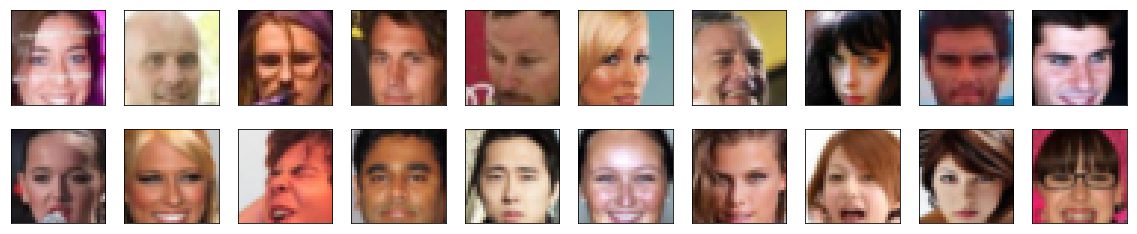

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    minimum, maximum = feature_range
    
    x = (x*(maximum-minimum)) + minimum
    
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.9843)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# helper conv function as taught in DCGANs
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

# helper deconv function for Generator later on.
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    conv_layer_t = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer_t)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.flatten_dim = (conv_dim*8)*2*2
        
        # Conv Layers
        # In 32*32
        self.conv1 = conv(3, conv_dim, kernel_size=4, batch_norm=False)
        # Out 16*16
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4)
        # Out 8*8
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4)
        # Out 4*4
        self.conv4 = conv(conv_dim*4, conv_dim*8, kernel_size=4)
        # Out 2*2
        
        # Output conv layer
        self.fc = nn.Linear(self.flatten_dim, 1)
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = self.leaky_relu(self.conv4(x))
        x = x.view(-1, self.flatten_dim)
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        # complete init function
        
        self.conv_dim = conv_dim
        self.flatten_dim = (conv_dim*8)*2*2
        
        self.fc = nn.Linear(z_size, self.flatten_dim)
        
        self.conv_t1 = deconv(conv_dim*8, conv_dim*4, kernel_size=4, batch_norm=True)
        self.conv_t2 = deconv(conv_dim*4, conv_dim*2, kernel_size=4, batch_norm=True)
        self.conv_t3 = deconv(conv_dim*2, conv_dim, kernel_size=4, batch_norm=True)
        self.conv_t4 = deconv(conv_dim, 3, kernel_size=4, batch_norm=False)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        
        x = F.relu(self.conv_t1(x))
        x = F.relu(self.conv_t2(x))
        x = F.relu(self.conv_t3(x))
        x = self.conv_t4(x)
        x = torch.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.normal_(0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (conv_t1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in tqdm(range(n_epochs)):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # Real Images
            if train_on_gpu:
                real_images = real_images.cuda()
                
            d_real = D(real_images)
            d_real_loss = real_loss(d_real)
            
            # Fake Images
            fakes = np.random.uniform(-1, 1, size=(batch_size, z_size))
            fakes = torch.from_numpy(fakes).float()
            
            if train_on_gpu:
                fakes = fakes.cuda()
                
            fake_images = G(fakes)
            
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake) 
            
            # Combine Losses
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # Create Fakes
            fakes = np.random.uniform(-1, 1, size=(batch_size, z_size))
            fakes = torch.from_numpy(fakes).float()
            
            if train_on_gpu:
                fakes = fakes.cuda()
                
            fake_images = G(fakes)
            
            # Calculate loss, but using flipped labels.
            
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake)
            
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [20]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [    1/   30] | d_loss: 1.2851 | g_loss: 0.9677
Epoch [    1/   30] | d_loss: 0.1214 | g_loss: 4.0496
Epoch [    1/   30] | d_loss: 0.0302 | g_loss: 5.0174
Epoch [    1/   30] | d_loss: 0.3222 | g_loss: 2.8474
Epoch [    1/   30] | d_loss: 0.2672 | g_loss: 3.2806
Epoch [    1/   30] | d_loss: 0.3891 | g_loss: 2.0103
Epoch [    1/   30] | d_loss: 0.5173 | g_loss: 2.8445
Epoch [    1/   30] | d_loss: 0.5779 | g_loss: 2.8544
Epoch [    1/   30] | d_loss: 0.8058 | g_loss: 2.4141
Epoch [    1/   30] | d_loss: 0.6410 | g_loss: 3.6336
Epoch [    1/   30] | d_loss: 1.1019 | g_loss: 2.9794
Epoch [    1/   30] | d_loss: 0.8744 | g_loss: 3.2876
Epoch [    1/   30] | d_loss: 0.6648 | g_loss: 1.8712
Epoch [    1/   30] | d_loss: 0.7402 | g_loss: 2.5404
Epoch [    1/   30] | d_loss: 1.0158 | g_loss: 1.4094


  3%|▎         | 1/30 [01:44<50:38, 104.78s/it]

Epoch [    2/   30] | d_loss: 0.7626 | g_loss: 1.3867
Epoch [    2/   30] | d_loss: 0.8097 | g_loss: 1.5147
Epoch [    2/   30] | d_loss: 0.7939 | g_loss: 2.5805
Epoch [    2/   30] | d_loss: 0.9115 | g_loss: 2.1480
Epoch [    2/   30] | d_loss: 0.9600 | g_loss: 2.1089
Epoch [    2/   30] | d_loss: 1.0125 | g_loss: 3.2382
Epoch [    2/   30] | d_loss: 0.8084 | g_loss: 1.8822
Epoch [    2/   30] | d_loss: 1.0674 | g_loss: 2.4117
Epoch [    2/   30] | d_loss: 0.6924 | g_loss: 2.0410
Epoch [    2/   30] | d_loss: 1.0374 | g_loss: 1.3610
Epoch [    2/   30] | d_loss: 0.9197 | g_loss: 1.4471
Epoch [    2/   30] | d_loss: 0.9961 | g_loss: 1.1748
Epoch [    2/   30] | d_loss: 0.9377 | g_loss: 1.9017
Epoch [    2/   30] | d_loss: 0.9852 | g_loss: 1.6957
Epoch [    2/   30] | d_loss: 1.0895 | g_loss: 2.2909


  7%|▋         | 2/30 [03:29<48:49, 104.64s/it]

Epoch [    3/   30] | d_loss: 0.9204 | g_loss: 1.5675
Epoch [    3/   30] | d_loss: 0.9422 | g_loss: 1.4783
Epoch [    3/   30] | d_loss: 1.0512 | g_loss: 1.5632
Epoch [    3/   30] | d_loss: 1.1299 | g_loss: 1.7650
Epoch [    3/   30] | d_loss: 0.8393 | g_loss: 1.6718
Epoch [    3/   30] | d_loss: 1.0784 | g_loss: 1.3003
Epoch [    3/   30] | d_loss: 0.8935 | g_loss: 2.1808
Epoch [    3/   30] | d_loss: 0.8599 | g_loss: 1.3182
Epoch [    3/   30] | d_loss: 1.2390 | g_loss: 1.7833
Epoch [    3/   30] | d_loss: 0.9275 | g_loss: 1.3653
Epoch [    3/   30] | d_loss: 0.8942 | g_loss: 1.3073
Epoch [    3/   30] | d_loss: 0.7451 | g_loss: 1.9376
Epoch [    3/   30] | d_loss: 0.9988 | g_loss: 1.2694
Epoch [    3/   30] | d_loss: 0.9403 | g_loss: 0.9450
Epoch [    3/   30] | d_loss: 0.8594 | g_loss: 1.6349


 10%|█         | 3/30 [05:13<47:03, 104.56s/it]

Epoch [    4/   30] | d_loss: 0.8776 | g_loss: 1.3640
Epoch [    4/   30] | d_loss: 1.1465 | g_loss: 2.3104
Epoch [    4/   30] | d_loss: 0.8353 | g_loss: 1.4156
Epoch [    4/   30] | d_loss: 0.9613 | g_loss: 1.8284
Epoch [    4/   30] | d_loss: 0.7943 | g_loss: 1.3971
Epoch [    4/   30] | d_loss: 0.7979 | g_loss: 1.4960
Epoch [    4/   30] | d_loss: 0.7276 | g_loss: 1.2035
Epoch [    4/   30] | d_loss: 0.8560 | g_loss: 1.1120
Epoch [    4/   30] | d_loss: 0.9375 | g_loss: 1.1415
Epoch [    4/   30] | d_loss: 1.5535 | g_loss: 1.3010
Epoch [    4/   30] | d_loss: 1.0718 | g_loss: 2.3752
Epoch [    4/   30] | d_loss: 0.9242 | g_loss: 1.0858
Epoch [    4/   30] | d_loss: 1.1930 | g_loss: 2.6046
Epoch [    4/   30] | d_loss: 0.8980 | g_loss: 0.8888
Epoch [    4/   30] | d_loss: 0.7089 | g_loss: 2.2862


 13%|█▎        | 4/30 [06:57<45:16, 104.49s/it]

Epoch [    5/   30] | d_loss: 0.8637 | g_loss: 0.7403
Epoch [    5/   30] | d_loss: 0.7119 | g_loss: 1.9002
Epoch [    5/   30] | d_loss: 0.9022 | g_loss: 1.2995
Epoch [    5/   30] | d_loss: 0.8328 | g_loss: 2.1732
Epoch [    5/   30] | d_loss: 0.9392 | g_loss: 0.8426
Epoch [    5/   30] | d_loss: 1.6567 | g_loss: 2.6171
Epoch [    5/   30] | d_loss: 0.7751 | g_loss: 2.2088
Epoch [    5/   30] | d_loss: 0.7387 | g_loss: 1.5036
Epoch [    5/   30] | d_loss: 0.8968 | g_loss: 1.3426
Epoch [    5/   30] | d_loss: 0.8219 | g_loss: 1.3988
Epoch [    5/   30] | d_loss: 0.7591 | g_loss: 2.1915
Epoch [    5/   30] | d_loss: 0.7426 | g_loss: 1.6643
Epoch [    5/   30] | d_loss: 0.6041 | g_loss: 1.4363
Epoch [    5/   30] | d_loss: 0.8188 | g_loss: 1.5115
Epoch [    5/   30] | d_loss: 0.7040 | g_loss: 1.9993


 17%|█▋        | 5/30 [08:42<43:31, 104.46s/it]

Epoch [    6/   30] | d_loss: 0.7162 | g_loss: 2.1443
Epoch [    6/   30] | d_loss: 0.7413 | g_loss: 2.4149
Epoch [    6/   30] | d_loss: 1.1326 | g_loss: 0.6160
Epoch [    6/   30] | d_loss: 0.7205 | g_loss: 1.6349
Epoch [    6/   30] | d_loss: 0.8517 | g_loss: 2.5543
Epoch [    6/   30] | d_loss: 0.7791 | g_loss: 1.7863
Epoch [    6/   30] | d_loss: 0.7771 | g_loss: 2.0182
Epoch [    6/   30] | d_loss: 0.9056 | g_loss: 1.8476
Epoch [    6/   30] | d_loss: 0.6500 | g_loss: 2.0198
Epoch [    6/   30] | d_loss: 0.7550 | g_loss: 1.9974
Epoch [    6/   30] | d_loss: 0.8730 | g_loss: 1.0325
Epoch [    6/   30] | d_loss: 0.8136 | g_loss: 2.4752
Epoch [    6/   30] | d_loss: 0.8496 | g_loss: 1.8334
Epoch [    6/   30] | d_loss: 0.6047 | g_loss: 1.5429
Epoch [    6/   30] | d_loss: 0.9956 | g_loss: 0.6498


 20%|██        | 6/30 [10:26<41:45, 104.41s/it]

Epoch [    7/   30] | d_loss: 1.0092 | g_loss: 2.6410
Epoch [    7/   30] | d_loss: 1.0385 | g_loss: 3.1804
Epoch [    7/   30] | d_loss: 0.6789 | g_loss: 1.9756
Epoch [    7/   30] | d_loss: 0.7790 | g_loss: 1.4529
Epoch [    7/   30] | d_loss: 1.1412 | g_loss: 3.1109
Epoch [    7/   30] | d_loss: 0.7073 | g_loss: 2.3866
Epoch [    7/   30] | d_loss: 0.7716 | g_loss: 2.0571
Epoch [    7/   30] | d_loss: 0.9220 | g_loss: 0.7406
Epoch [    7/   30] | d_loss: 0.8882 | g_loss: 0.9006
Epoch [    7/   30] | d_loss: 0.7405 | g_loss: 2.0045
Epoch [    7/   30] | d_loss: 0.9159 | g_loss: 1.1649
Epoch [    7/   30] | d_loss: 1.1241 | g_loss: 0.8294
Epoch [    7/   30] | d_loss: 1.5304 | g_loss: 1.1585
Epoch [    7/   30] | d_loss: 0.6802 | g_loss: 2.0777
Epoch [    7/   30] | d_loss: 0.6130 | g_loss: 1.6801


 23%|██▎       | 7/30 [12:10<40:00, 104.37s/it]

Epoch [    8/   30] | d_loss: 0.7867 | g_loss: 2.0193
Epoch [    8/   30] | d_loss: 0.6441 | g_loss: 1.9853
Epoch [    8/   30] | d_loss: 0.8371 | g_loss: 1.5420
Epoch [    8/   30] | d_loss: 0.7189 | g_loss: 1.5318
Epoch [    8/   30] | d_loss: 0.9162 | g_loss: 2.6500
Epoch [    8/   30] | d_loss: 0.8208 | g_loss: 1.1025
Epoch [    8/   30] | d_loss: 0.6766 | g_loss: 1.9211
Epoch [    8/   30] | d_loss: 0.9539 | g_loss: 2.7705
Epoch [    8/   30] | d_loss: 0.8175 | g_loss: 1.2218
Epoch [    8/   30] | d_loss: 0.7974 | g_loss: 1.8673
Epoch [    8/   30] | d_loss: 0.6462 | g_loss: 1.3327
Epoch [    8/   30] | d_loss: 0.5355 | g_loss: 1.6041
Epoch [    8/   30] | d_loss: 0.8350 | g_loss: 1.8197
Epoch [    8/   30] | d_loss: 0.9425 | g_loss: 3.1087
Epoch [    8/   30] | d_loss: 1.2974 | g_loss: 3.5573


 27%|██▋       | 8/30 [13:54<38:14, 104.29s/it]

Epoch [    9/   30] | d_loss: 1.8427 | g_loss: 1.5194
Epoch [    9/   30] | d_loss: 0.7994 | g_loss: 1.7456
Epoch [    9/   30] | d_loss: 0.7223 | g_loss: 1.4008
Epoch [    9/   30] | d_loss: 0.9778 | g_loss: 1.1509
Epoch [    9/   30] | d_loss: 0.7445 | g_loss: 1.8709
Epoch [    9/   30] | d_loss: 0.5585 | g_loss: 1.6003
Epoch [    9/   30] | d_loss: 0.7110 | g_loss: 1.4179
Epoch [    9/   30] | d_loss: 0.6823 | g_loss: 1.8626
Epoch [    9/   30] | d_loss: 0.7133 | g_loss: 2.8853
Epoch [    9/   30] | d_loss: 1.0074 | g_loss: 0.5639
Epoch [    9/   30] | d_loss: 0.6740 | g_loss: 2.9090
Epoch [    9/   30] | d_loss: 0.7799 | g_loss: 0.8722
Epoch [    9/   30] | d_loss: 0.7864 | g_loss: 1.1681
Epoch [    9/   30] | d_loss: 0.6290 | g_loss: 1.2029
Epoch [    9/   30] | d_loss: 0.7213 | g_loss: 1.9259


 30%|███       | 9/30 [15:39<36:29, 104.28s/it]

Epoch [   10/   30] | d_loss: 0.8783 | g_loss: 2.5630
Epoch [   10/   30] | d_loss: 0.9953 | g_loss: 3.2036
Epoch [   10/   30] | d_loss: 0.6880 | g_loss: 1.6059
Epoch [   10/   30] | d_loss: 0.6810 | g_loss: 1.1749
Epoch [   10/   30] | d_loss: 0.7082 | g_loss: 2.4515
Epoch [   10/   30] | d_loss: 0.8924 | g_loss: 2.2621
Epoch [   10/   30] | d_loss: 1.3567 | g_loss: 1.2748
Epoch [   10/   30] | d_loss: 0.6632 | g_loss: 2.5926
Epoch [   10/   30] | d_loss: 0.6595 | g_loss: 2.6330
Epoch [   10/   30] | d_loss: 1.0953 | g_loss: 1.1063
Epoch [   10/   30] | d_loss: 0.4502 | g_loss: 2.0027
Epoch [   10/   30] | d_loss: 0.6865 | g_loss: 1.4553
Epoch [   10/   30] | d_loss: 0.5720 | g_loss: 1.4621
Epoch [   10/   30] | d_loss: 1.0735 | g_loss: 0.6450
Epoch [   10/   30] | d_loss: 0.5861 | g_loss: 1.5469


 33%|███▎      | 10/30 [17:23<34:45, 104.26s/it]

Epoch [   11/   30] | d_loss: 0.6969 | g_loss: 1.2153
Epoch [   11/   30] | d_loss: 0.6183 | g_loss: 1.5076
Epoch [   11/   30] | d_loss: 0.6518 | g_loss: 1.5209
Epoch [   11/   30] | d_loss: 0.5541 | g_loss: 1.9760
Epoch [   11/   30] | d_loss: 0.6181 | g_loss: 1.7096
Epoch [   11/   30] | d_loss: 0.5935 | g_loss: 2.1571
Epoch [   11/   30] | d_loss: 0.5722 | g_loss: 2.2561
Epoch [   11/   30] | d_loss: 0.7925 | g_loss: 1.5407
Epoch [   11/   30] | d_loss: 0.6316 | g_loss: 2.8927
Epoch [   11/   30] | d_loss: 0.6409 | g_loss: 1.3415
Epoch [   11/   30] | d_loss: 0.6538 | g_loss: 2.4038
Epoch [   11/   30] | d_loss: 0.4324 | g_loss: 1.7116
Epoch [   11/   30] | d_loss: 0.7209 | g_loss: 3.6694
Epoch [   11/   30] | d_loss: 0.3858 | g_loss: 2.0262
Epoch [   11/   30] | d_loss: 0.8178 | g_loss: 1.1781


 37%|███▋      | 11/30 [19:07<33:00, 104.25s/it]

Epoch [   12/   30] | d_loss: 0.5604 | g_loss: 2.2180
Epoch [   12/   30] | d_loss: 0.5958 | g_loss: 3.5460
Epoch [   12/   30] | d_loss: 0.5856 | g_loss: 1.2639
Epoch [   12/   30] | d_loss: 0.3967 | g_loss: 2.6352
Epoch [   12/   30] | d_loss: 0.5911 | g_loss: 2.7654
Epoch [   12/   30] | d_loss: 0.5777 | g_loss: 1.8288
Epoch [   12/   30] | d_loss: 0.5895 | g_loss: 2.1874
Epoch [   12/   30] | d_loss: 0.7732 | g_loss: 0.9665
Epoch [   12/   30] | d_loss: 0.6789 | g_loss: 1.7308
Epoch [   12/   30] | d_loss: 0.4422 | g_loss: 1.6845
Epoch [   12/   30] | d_loss: 0.9031 | g_loss: 4.7005
Epoch [   12/   30] | d_loss: 0.6517 | g_loss: 3.4289
Epoch [   12/   30] | d_loss: 0.6456 | g_loss: 1.4391
Epoch [   12/   30] | d_loss: 0.6079 | g_loss: 2.6611
Epoch [   12/   30] | d_loss: 0.5217 | g_loss: 3.1411


 40%|████      | 12/30 [20:51<31:16, 104.26s/it]

Epoch [   13/   30] | d_loss: 0.4531 | g_loss: 2.3795
Epoch [   13/   30] | d_loss: 0.4616 | g_loss: 1.4508
Epoch [   13/   30] | d_loss: 0.4268 | g_loss: 2.9583
Epoch [   13/   30] | d_loss: 0.4569 | g_loss: 2.2378
Epoch [   13/   30] | d_loss: 0.4032 | g_loss: 2.2425
Epoch [   13/   30] | d_loss: 0.4560 | g_loss: 2.2271
Epoch [   13/   30] | d_loss: 0.6829 | g_loss: 1.6982
Epoch [   13/   30] | d_loss: 0.7679 | g_loss: 1.7441
Epoch [   13/   30] | d_loss: 0.6209 | g_loss: 1.1565
Epoch [   13/   30] | d_loss: 0.3866 | g_loss: 2.2899
Epoch [   13/   30] | d_loss: 0.4151 | g_loss: 2.3066
Epoch [   13/   30] | d_loss: 0.3634 | g_loss: 2.0332
Epoch [   13/   30] | d_loss: 0.8048 | g_loss: 1.0161
Epoch [   13/   30] | d_loss: 0.6658 | g_loss: 0.9074
Epoch [   13/   30] | d_loss: 0.6423 | g_loss: 1.3981


 43%|████▎     | 13/30 [22:36<29:32, 104.26s/it]

Epoch [   14/   30] | d_loss: 0.4584 | g_loss: 1.8822
Epoch [   14/   30] | d_loss: 0.3013 | g_loss: 3.2331
Epoch [   14/   30] | d_loss: 0.5185 | g_loss: 2.9238
Epoch [   14/   30] | d_loss: 0.5412 | g_loss: 3.6205
Epoch [   14/   30] | d_loss: 0.8517 | g_loss: 4.5525
Epoch [   14/   30] | d_loss: 0.6569 | g_loss: 1.9849
Epoch [   14/   30] | d_loss: 1.7574 | g_loss: 1.8296
Epoch [   14/   30] | d_loss: 0.7700 | g_loss: 3.8842
Epoch [   14/   30] | d_loss: 0.7364 | g_loss: 1.1337
Epoch [   14/   30] | d_loss: 0.5438 | g_loss: 2.3225
Epoch [   14/   30] | d_loss: 0.5405 | g_loss: 2.8324
Epoch [   14/   30] | d_loss: 0.4484 | g_loss: 2.6016
Epoch [   14/   30] | d_loss: 0.5541 | g_loss: 2.8053
Epoch [   14/   30] | d_loss: 0.6557 | g_loss: 3.2130
Epoch [   14/   30] | d_loss: 0.7838 | g_loss: 2.2824


 47%|████▋     | 14/30 [24:20<27:47, 104.22s/it]

Epoch [   15/   30] | d_loss: 1.1420 | g_loss: 2.0857
Epoch [   15/   30] | d_loss: 0.4273 | g_loss: 2.3974
Epoch [   15/   30] | d_loss: 0.5996 | g_loss: 3.6942
Epoch [   15/   30] | d_loss: 0.5918 | g_loss: 1.0979
Epoch [   15/   30] | d_loss: 0.8018 | g_loss: 2.1206
Epoch [   15/   30] | d_loss: 0.3804 | g_loss: 2.1035
Epoch [   15/   30] | d_loss: 0.4822 | g_loss: 2.2758
Epoch [   15/   30] | d_loss: 0.5063 | g_loss: 2.4693
Epoch [   15/   30] | d_loss: 0.6852 | g_loss: 2.5795
Epoch [   15/   30] | d_loss: 0.4829 | g_loss: 2.9788
Epoch [   15/   30] | d_loss: 0.4096 | g_loss: 2.1974
Epoch [   15/   30] | d_loss: 0.7998 | g_loss: 2.6840
Epoch [   15/   30] | d_loss: 0.5628 | g_loss: 1.9621
Epoch [   15/   30] | d_loss: 0.6316 | g_loss: 2.4115
Epoch [   15/   30] | d_loss: 0.4585 | g_loss: 2.3348


 50%|█████     | 15/30 [26:04<26:03, 104.21s/it]

Epoch [   16/   30] | d_loss: 0.6573 | g_loss: 2.3118
Epoch [   16/   30] | d_loss: 0.3332 | g_loss: 3.1757
Epoch [   16/   30] | d_loss: 0.4513 | g_loss: 1.9254
Epoch [   16/   30] | d_loss: 0.5847 | g_loss: 3.2040
Epoch [   16/   30] | d_loss: 0.5548 | g_loss: 2.4147
Epoch [   16/   30] | d_loss: 0.5555 | g_loss: 2.9814
Epoch [   16/   30] | d_loss: 0.4725 | g_loss: 3.2139
Epoch [   16/   30] | d_loss: 0.4126 | g_loss: 2.9100
Epoch [   16/   30] | d_loss: 0.5452 | g_loss: 1.5874
Epoch [   16/   30] | d_loss: 0.5112 | g_loss: 1.9847
Epoch [   16/   30] | d_loss: 0.3299 | g_loss: 2.7927
Epoch [   16/   30] | d_loss: 0.4562 | g_loss: 1.9784
Epoch [   16/   30] | d_loss: 0.3097 | g_loss: 3.0204
Epoch [   16/   30] | d_loss: 0.4991 | g_loss: 2.7572
Epoch [   16/   30] | d_loss: 0.5740 | g_loss: 1.8004


 53%|█████▎    | 16/30 [27:48<24:19, 104.24s/it]

Epoch [   17/   30] | d_loss: 0.8347 | g_loss: 2.6317
Epoch [   17/   30] | d_loss: 0.4046 | g_loss: 2.7637
Epoch [   17/   30] | d_loss: 0.3693 | g_loss: 2.6492
Epoch [   17/   30] | d_loss: 0.4249 | g_loss: 2.5831
Epoch [   17/   30] | d_loss: 0.2897 | g_loss: 2.8314
Epoch [   17/   30] | d_loss: 0.3458 | g_loss: 2.9929
Epoch [   17/   30] | d_loss: 0.4226 | g_loss: 2.0933
Epoch [   17/   30] | d_loss: 0.5593 | g_loss: 3.6267
Epoch [   17/   30] | d_loss: 0.5926 | g_loss: 2.6251
Epoch [   17/   30] | d_loss: 0.3322 | g_loss: 2.7554
Epoch [   17/   30] | d_loss: 0.3090 | g_loss: 2.3667
Epoch [   17/   30] | d_loss: 0.4446 | g_loss: 3.6600
Epoch [   17/   30] | d_loss: 0.6054 | g_loss: 2.6684
Epoch [   17/   30] | d_loss: 0.4095 | g_loss: 4.3811
Epoch [   17/   30] | d_loss: 0.5897 | g_loss: 4.9988


 57%|█████▋    | 17/30 [29:32<22:34, 104.22s/it]

Epoch [   18/   30] | d_loss: 1.3823 | g_loss: 1.1313
Epoch [   18/   30] | d_loss: 0.3736 | g_loss: 2.3015
Epoch [   18/   30] | d_loss: 0.2942 | g_loss: 2.6198
Epoch [   18/   30] | d_loss: 0.4583 | g_loss: 2.6188
Epoch [   18/   30] | d_loss: 0.3262 | g_loss: 2.3752
Epoch [   18/   30] | d_loss: 0.3823 | g_loss: 2.3148
Epoch [   18/   30] | d_loss: 0.3126 | g_loss: 2.9609
Epoch [   18/   30] | d_loss: 0.3605 | g_loss: 2.9651
Epoch [   18/   30] | d_loss: 0.3649 | g_loss: 2.7690
Epoch [   18/   30] | d_loss: 0.9179 | g_loss: 4.9492
Epoch [   18/   30] | d_loss: 0.3523 | g_loss: 2.2025
Epoch [   18/   30] | d_loss: 0.3685 | g_loss: 3.1493
Epoch [   18/   30] | d_loss: 0.3127 | g_loss: 1.7684
Epoch [   18/   30] | d_loss: 0.6268 | g_loss: 2.5317
Epoch [   18/   30] | d_loss: 0.3252 | g_loss: 3.1338


 60%|██████    | 18/30 [31:17<20:50, 104.22s/it]

Epoch [   19/   30] | d_loss: 1.2770 | g_loss: 5.3787
Epoch [   19/   30] | d_loss: 0.6413 | g_loss: 1.2934
Epoch [   19/   30] | d_loss: 0.7814 | g_loss: 1.6452
Epoch [   19/   30] | d_loss: 0.7059 | g_loss: 3.7555
Epoch [   19/   30] | d_loss: 0.3946 | g_loss: 2.5496
Epoch [   19/   30] | d_loss: 0.2746 | g_loss: 3.3618
Epoch [   19/   30] | d_loss: 0.4589 | g_loss: 4.2718
Epoch [   19/   30] | d_loss: 0.2969 | g_loss: 0.8070
Epoch [   19/   30] | d_loss: 0.4021 | g_loss: 1.9211
Epoch [   19/   30] | d_loss: 0.3532 | g_loss: 4.7748
Epoch [   19/   30] | d_loss: 0.4492 | g_loss: 2.2969
Epoch [   19/   30] | d_loss: 0.3231 | g_loss: 2.5307
Epoch [   19/   30] | d_loss: 0.3589 | g_loss: 2.3508
Epoch [   19/   30] | d_loss: 0.2931 | g_loss: 1.7333
Epoch [   19/   30] | d_loss: 0.4218 | g_loss: 2.9908


 63%|██████▎   | 19/30 [33:01<19:06, 104.21s/it]

Epoch [   20/   30] | d_loss: 0.4332 | g_loss: 3.3128
Epoch [   20/   30] | d_loss: 0.5057 | g_loss: 1.9037
Epoch [   20/   30] | d_loss: 0.4643 | g_loss: 1.5592
Epoch [   20/   30] | d_loss: 0.2703 | g_loss: 2.4505
Epoch [   20/   30] | d_loss: 0.3447 | g_loss: 2.6767
Epoch [   20/   30] | d_loss: 0.4133 | g_loss: 1.8381
Epoch [   20/   30] | d_loss: 0.4605 | g_loss: 2.2573
Epoch [   20/   30] | d_loss: 0.2275 | g_loss: 2.8541
Epoch [   20/   30] | d_loss: 0.2577 | g_loss: 2.8636
Epoch [   20/   30] | d_loss: 1.0232 | g_loss: 0.9730
Epoch [   20/   30] | d_loss: 0.2775 | g_loss: 2.7631
Epoch [   20/   30] | d_loss: 0.2867 | g_loss: 3.0136
Epoch [   20/   30] | d_loss: 0.4907 | g_loss: 4.1341
Epoch [   20/   30] | d_loss: 0.2864 | g_loss: 4.6400
Epoch [   20/   30] | d_loss: 0.3166 | g_loss: 1.4982


 67%|██████▋   | 20/30 [34:45<17:22, 104.24s/it]

Epoch [   21/   30] | d_loss: 0.6234 | g_loss: 4.1648
Epoch [   21/   30] | d_loss: 0.4535 | g_loss: 2.1419
Epoch [   21/   30] | d_loss: 0.3842 | g_loss: 2.1085
Epoch [   21/   30] | d_loss: 0.8227 | g_loss: 2.7127
Epoch [   21/   30] | d_loss: 0.3653 | g_loss: 2.3883
Epoch [   21/   30] | d_loss: 0.7447 | g_loss: 2.0377
Epoch [   21/   30] | d_loss: 0.4857 | g_loss: 2.1886
Epoch [   21/   30] | d_loss: 1.0570 | g_loss: 1.4045
Epoch [   21/   30] | d_loss: 0.2590 | g_loss: 3.3924
Epoch [   21/   30] | d_loss: 1.0809 | g_loss: 5.4635
Epoch [   21/   30] | d_loss: 0.2661 | g_loss: 3.3188
Epoch [   21/   30] | d_loss: 0.2511 | g_loss: 3.1741
Epoch [   21/   30] | d_loss: 0.5027 | g_loss: 3.6453
Epoch [   21/   30] | d_loss: 3.3459 | g_loss: 3.5476
Epoch [   21/   30] | d_loss: 0.1611 | g_loss: 4.6284


 70%|███████   | 21/30 [36:29<15:38, 104.23s/it]

Epoch [   22/   30] | d_loss: 1.6081 | g_loss: 1.0828
Epoch [   22/   30] | d_loss: 0.2895 | g_loss: 2.6085
Epoch [   22/   30] | d_loss: 0.4095 | g_loss: 3.6375
Epoch [   22/   30] | d_loss: 0.2547 | g_loss: 3.6238
Epoch [   22/   30] | d_loss: 0.2507 | g_loss: 3.0614
Epoch [   22/   30] | d_loss: 0.2794 | g_loss: 2.6216
Epoch [   22/   30] | d_loss: 0.3288 | g_loss: 2.7618
Epoch [   22/   30] | d_loss: 0.2059 | g_loss: 3.9783
Epoch [   22/   30] | d_loss: 0.4311 | g_loss: 2.0298
Epoch [   22/   30] | d_loss: 0.3606 | g_loss: 1.5618
Epoch [   22/   30] | d_loss: 0.8431 | g_loss: 0.9516
Epoch [   22/   30] | d_loss: 0.1277 | g_loss: 3.2568
Epoch [   22/   30] | d_loss: 0.1942 | g_loss: 3.8466
Epoch [   22/   30] | d_loss: 0.1998 | g_loss: 5.0053
Epoch [   22/   30] | d_loss: 0.4918 | g_loss: 1.3623


 73%|███████▎  | 22/30 [38:14<13:54, 104.26s/it]

Epoch [   23/   30] | d_loss: 0.3855 | g_loss: 2.3638
Epoch [   23/   30] | d_loss: 0.7710 | g_loss: 5.0491
Epoch [   23/   30] | d_loss: 0.5186 | g_loss: 2.4357
Epoch [   23/   30] | d_loss: 0.2560 | g_loss: 3.1979
Epoch [   23/   30] | d_loss: 0.3375 | g_loss: 3.7681
Epoch [   23/   30] | d_loss: 0.2507 | g_loss: 4.3039
Epoch [   23/   30] | d_loss: 0.6096 | g_loss: 4.3967
Epoch [   23/   30] | d_loss: 0.2828 | g_loss: 3.1857
Epoch [   23/   30] | d_loss: 0.3632 | g_loss: 2.4781
Epoch [   23/   30] | d_loss: 0.2565 | g_loss: 3.3528
Epoch [   23/   30] | d_loss: 0.3546 | g_loss: 2.7401
Epoch [   23/   30] | d_loss: 0.8382 | g_loss: 0.8581
Epoch [   23/   30] | d_loss: 0.1953 | g_loss: 3.1897
Epoch [   23/   30] | d_loss: 0.2343 | g_loss: 3.5316
Epoch [   23/   30] | d_loss: 0.1426 | g_loss: 3.2294


 77%|███████▋  | 23/30 [39:58<12:10, 104.29s/it]

Epoch [   24/   30] | d_loss: 0.1837 | g_loss: 2.2768
Epoch [   24/   30] | d_loss: 0.3168 | g_loss: 2.8943
Epoch [   24/   30] | d_loss: 0.3677 | g_loss: 2.9448
Epoch [   24/   30] | d_loss: 0.4401 | g_loss: 3.5106
Epoch [   24/   30] | d_loss: 0.2765 | g_loss: 3.2672
Epoch [   24/   30] | d_loss: 0.1703 | g_loss: 3.7194
Epoch [   24/   30] | d_loss: 0.2934 | g_loss: 3.3241
Epoch [   24/   30] | d_loss: 0.4184 | g_loss: 4.1925
Epoch [   24/   30] | d_loss: 0.2515 | g_loss: 3.2544
Epoch [   24/   30] | d_loss: 0.2522 | g_loss: 3.2539
Epoch [   24/   30] | d_loss: 0.3231 | g_loss: 2.7974
Epoch [   24/   30] | d_loss: 0.1706 | g_loss: 4.0005
Epoch [   24/   30] | d_loss: 0.2066 | g_loss: 2.6959
Epoch [   24/   30] | d_loss: 0.2529 | g_loss: 3.0799
Epoch [   24/   30] | d_loss: 0.2928 | g_loss: 2.9429


 80%|████████  | 24/30 [41:42<10:25, 104.22s/it]

Epoch [   25/   30] | d_loss: 0.4019 | g_loss: 1.5611
Epoch [   25/   30] | d_loss: 0.1689 | g_loss: 4.2961
Epoch [   25/   30] | d_loss: 0.4679 | g_loss: 3.2754
Epoch [   25/   30] | d_loss: 0.1154 | g_loss: 2.5664
Epoch [   25/   30] | d_loss: 1.1800 | g_loss: 6.3811
Epoch [   25/   30] | d_loss: 0.2589 | g_loss: 3.4616
Epoch [   25/   30] | d_loss: 0.1722 | g_loss: 4.3199
Epoch [   25/   30] | d_loss: 0.1631 | g_loss: 3.5289
Epoch [   25/   30] | d_loss: 0.1604 | g_loss: 3.4923
Epoch [   25/   30] | d_loss: 0.2103 | g_loss: 2.3240
Epoch [   25/   30] | d_loss: 1.1080 | g_loss: 0.9869
Epoch [   25/   30] | d_loss: 0.2141 | g_loss: 2.4869
Epoch [   25/   30] | d_loss: 0.2812 | g_loss: 2.7434
Epoch [   25/   30] | d_loss: 0.2230 | g_loss: 3.1900
Epoch [   25/   30] | d_loss: 0.5431 | g_loss: 5.5663


 83%|████████▎ | 25/30 [43:26<08:41, 104.22s/it]

Epoch [   26/   30] | d_loss: 0.9768 | g_loss: 2.9004
Epoch [   26/   30] | d_loss: 0.2652 | g_loss: 3.3932
Epoch [   26/   30] | d_loss: 0.2830 | g_loss: 3.2725
Epoch [   26/   30] | d_loss: 0.2748 | g_loss: 2.9411
Epoch [   26/   30] | d_loss: 0.1799 | g_loss: 3.8229
Epoch [   26/   30] | d_loss: 0.3061 | g_loss: 1.3117
Epoch [   26/   30] | d_loss: 0.4363 | g_loss: 3.8837
Epoch [   26/   30] | d_loss: 0.3506 | g_loss: 3.3063
Epoch [   26/   30] | d_loss: 0.2794 | g_loss: 3.3672
Epoch [   26/   30] | d_loss: 0.4625 | g_loss: 5.0586
Epoch [   26/   30] | d_loss: 0.2125 | g_loss: 2.9132
Epoch [   26/   30] | d_loss: 0.1555 | g_loss: 4.4118
Epoch [   26/   30] | d_loss: 0.1758 | g_loss: 3.6532
Epoch [   26/   30] | d_loss: 0.6158 | g_loss: 5.1412
Epoch [   26/   30] | d_loss: 0.3829 | g_loss: 3.2121


 87%|████████▋ | 26/30 [45:11<06:56, 104.24s/it]

Epoch [   27/   30] | d_loss: 0.4938 | g_loss: 2.5813
Epoch [   27/   30] | d_loss: 0.1949 | g_loss: 3.2357
Epoch [   27/   30] | d_loss: 1.4011 | g_loss: 1.1261
Epoch [   27/   30] | d_loss: 0.1812 | g_loss: 2.9828
Epoch [   27/   30] | d_loss: 0.1322 | g_loss: 2.7317
Epoch [   27/   30] | d_loss: 0.1847 | g_loss: 3.2687
Epoch [   27/   30] | d_loss: 0.7130 | g_loss: 3.9418
Epoch [   27/   30] | d_loss: 0.9650 | g_loss: 6.7884
Epoch [   27/   30] | d_loss: 0.1702 | g_loss: 4.7946
Epoch [   27/   30] | d_loss: 0.3617 | g_loss: 4.8391
Epoch [   27/   30] | d_loss: 0.2265 | g_loss: 3.2747
Epoch [   27/   30] | d_loss: 0.1545 | g_loss: 1.8097
Epoch [   27/   30] | d_loss: 0.2386 | g_loss: 3.0261
Epoch [   27/   30] | d_loss: 2.4380 | g_loss: 6.2775
Epoch [   27/   30] | d_loss: 0.2487 | g_loss: 2.8764


 90%|█████████ | 27/30 [46:55<05:12, 104.27s/it]

Epoch [   28/   30] | d_loss: 0.7982 | g_loss: 3.9743
Epoch [   28/   30] | d_loss: 0.1719 | g_loss: 2.0642
Epoch [   28/   30] | d_loss: 0.1308 | g_loss: 4.3689
Epoch [   28/   30] | d_loss: 0.4353 | g_loss: 6.1560
Epoch [   28/   30] | d_loss: 0.0980 | g_loss: 3.6330
Epoch [   28/   30] | d_loss: 0.2642 | g_loss: 1.9569
Epoch [   28/   30] | d_loss: 0.2289 | g_loss: 4.2385
Epoch [   28/   30] | d_loss: 0.5336 | g_loss: 3.3328
Epoch [   28/   30] | d_loss: 0.3360 | g_loss: 4.0701
Epoch [   28/   30] | d_loss: 0.2409 | g_loss: 4.8696
Epoch [   28/   30] | d_loss: 0.1680 | g_loss: 3.7851
Epoch [   28/   30] | d_loss: 0.2815 | g_loss: 2.0506
Epoch [   28/   30] | d_loss: 0.1529 | g_loss: 4.2060
Epoch [   28/   30] | d_loss: 0.9858 | g_loss: 2.0138
Epoch [   28/   30] | d_loss: 0.1673 | g_loss: 3.2969


 93%|█████████▎| 28/30 [48:39<03:28, 104.27s/it]

Epoch [   29/   30] | d_loss: 0.4202 | g_loss: 0.9394
Epoch [   29/   30] | d_loss: 0.3309 | g_loss: 2.1527
Epoch [   29/   30] | d_loss: 0.7902 | g_loss: 6.1950
Epoch [   29/   30] | d_loss: 0.1318 | g_loss: 2.8023
Epoch [   29/   30] | d_loss: 0.2243 | g_loss: 4.4920
Epoch [   29/   30] | d_loss: 0.2510 | g_loss: 2.4951
Epoch [   29/   30] | d_loss: 0.3758 | g_loss: 3.9019
Epoch [   29/   30] | d_loss: 0.4634 | g_loss: 2.5763
Epoch [   29/   30] | d_loss: 0.6111 | g_loss: 4.3803
Epoch [   29/   30] | d_loss: 0.1212 | g_loss: 3.8739
Epoch [   29/   30] | d_loss: 0.1999 | g_loss: 3.6589
Epoch [   29/   30] | d_loss: 0.2559 | g_loss: 4.0842
Epoch [   29/   30] | d_loss: 0.7814 | g_loss: 4.6374
Epoch [   29/   30] | d_loss: 0.2676 | g_loss: 2.2643
Epoch [   29/   30] | d_loss: 1.5155 | g_loss: 0.8887


 97%|█████████▋| 29/30 [50:23<01:44, 104.26s/it]

Epoch [   30/   30] | d_loss: 0.4307 | g_loss: 1.6288
Epoch [   30/   30] | d_loss: 0.1126 | g_loss: 4.7065
Epoch [   30/   30] | d_loss: 0.1172 | g_loss: 4.9070
Epoch [   30/   30] | d_loss: 0.1007 | g_loss: 5.2935
Epoch [   30/   30] | d_loss: 2.2171 | g_loss: 3.6527
Epoch [   30/   30] | d_loss: 0.1897 | g_loss: 4.0856
Epoch [   30/   30] | d_loss: 0.1157 | g_loss: 2.9513
Epoch [   30/   30] | d_loss: 0.1913 | g_loss: 2.7043
Epoch [   30/   30] | d_loss: 0.2876 | g_loss: 3.0135
Epoch [   30/   30] | d_loss: 0.3131 | g_loss: 4.1649
Epoch [   30/   30] | d_loss: 0.1350 | g_loss: 3.1091
Epoch [   30/   30] | d_loss: 0.3348 | g_loss: 2.3125
Epoch [   30/   30] | d_loss: 0.9494 | g_loss: 0.9886
Epoch [   30/   30] | d_loss: 0.3995 | g_loss: 3.1436
Epoch [   30/   30] | d_loss: 0.1606 | g_loss: 3.6595


100%|██████████| 30/30 [52:08<00:00, 104.28s/it]


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

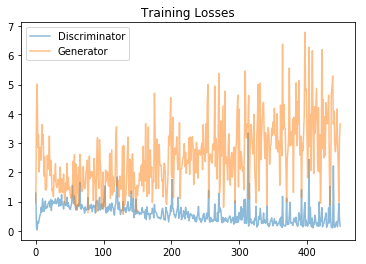

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

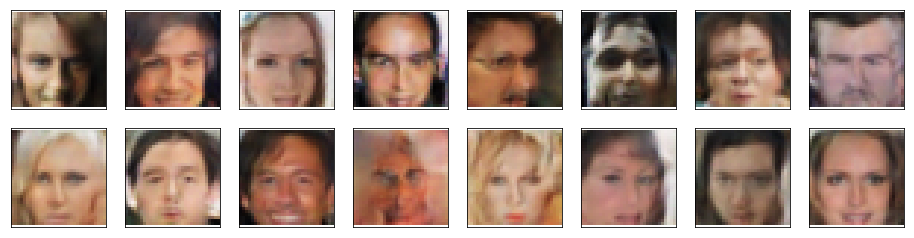

In [24]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

Dataset bias: As mentioned, the dataset is made up entirely of celebrities, limiting the possible faces generated as a result. There are far more white people featured in the dataset than people of colour. Furthermore, celebrities have a tendency to look photogenic, and subscribe to the media's standards of beauty. Consequently, there is a significant number of appearances that are not featured in training and thus will not be replicated in the results. Higher resolution images may also give better results.

Model size: A deeper network may be able to generate buch more realistic faces, as it will be able to pick up more features. This would however take a long time to train. It would be interesting to find some way to apply transfer learning to a DCGAN and perhaps benefit from deeper models provided freely.

Optimization strategy: Since the Generator loss seemed to gradually increase over time, perhaps stopping it at 20 epochs would provide better results. On the other hand, training for longer might make the generator learn a articularly effective feature somewhere down the line. More experimentation with this would be ideal. The literture suggests that Adam may be the best optimiser for this sort of task, but perhaps different learning rates and beta values may provide beter generated images.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.